# Redis API for Bitcoin Price Analytics

This notebook demonstrates the functionality of our Redis and CoinGecko API wrapper layer for Bitcoin price analytics. The API allows for:

- Connecting to Redis cloud database
- Fetching Bitcoin price data from CoinGecko API
- Storing Bitcoin data in Redis using various data structures
- Retrieving and analyzing historical price data
- Real-time price updates using Redis Pub/Sub
- Time series analysis and visualization

Refer to Redis.API.md for detailed documentation on the API design and implementation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import logging

# Import our Redis utils
from Redis_utils import *

# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Database Connection and Setup 

## Redis Connection and Setup

First, we'll connect to our Redis cloud instance using the connection parameters. Redis Cloud provides a fully-managed Redis service with data persistence.

### Redis Connection 

In [3]:
# Redis connection parameters
REDIS_HOST = ''
REDIS_PORT = 14816
REDIS_PASSWORD = ''

# Connect to Redis
redis_conn = connect_to_redis(REDIS_HOST, REDIS_PORT, REDIS_PASSWORD)
print("Connected to Redis successfully")

2025-05-01 15:43:06,222 - Redis_utils - INFO - Successfully connected to Redis


Connected to Redis successfully


## Fetch and Store Bitcoin Data

Now we'll fetch Bitcoin price data from the CoinGecko API and store it in Redis. We'll use various Redis data structures:

- Strings for current price
- Hashes for complete data points
- Sorted Sets for time series data

This demonstrates how Redis can be used for different data access patterns.

### Data Fetching 

In [4]:
# Fetch current Bitcoin price data
bitcoin_data = fetch_bitcoin_price(currency='usd')
print(f"Current Bitcoin price: ${bitcoin_data['usd']:,.2f}")
print(f"24h change: {bitcoin_data['usd_24h_change']:.2f}%")
print(f"Market cap: ${bitcoin_data['usd_market_cap']:,.2f}")

# Store data in Redis
success = store_bitcoin_price(redis_conn, bitcoin_data)
print(f"Data stored successfully: {success}")

# Get stored current price
stored_price = get_current_bitcoin_price(redis_conn)
print(f"Retrieved current price from Redis: ${stored_price:,.2f}")

2025-05-01 15:43:33,277 - Redis_utils - INFO - Successfully fetched Bitcoin price: 96650 USD
2025-05-01 15:43:33,311 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis


Current Bitcoin price: $96,650.00
24h change: 2.89%
Market cap: $1,919,379,356,304.60
Data stored successfully: True
Retrieved current price from Redis: $96,650.00


### Retrieve Historical Data

Fetch Historical Bitcoin Data

Let's fetch some historical Bitcoin price data from CoinGecko API and store it in Redis for analysis.

In [5]:
# Fetch historical data (last 7 days)
historical_data = fetch_bitcoin_historical(days=7, currency='usd')

# Display basic info about the data
print(f"Retrieved {len(historical_data['prices'])} price data points")
print(f"Retrieved {len(historical_data['market_caps'])} market cap data points")
print(f"Retrieved {len(historical_data['total_volumes'])} volume data points")

# Sample the first few price points
for timestamp_ms, price in historical_data['prices'][:5]:
    timestamp = datetime.fromtimestamp(timestamp_ms/1000)
    print(f"{timestamp}: ${price:,.2f}")

2025-05-01 15:43:39,823 - Redis_utils - INFO - Successfully fetched historical Bitcoin data for the last 7 days


Retrieved 169 price data points
Retrieved 169 market cap data points
Retrieved 169 volume data points
2025-04-24 16:04:41.416000: $93,646.96
2025-04-24 17:04:09.109000: $93,499.23
2025-04-24 18:00:03.429000: $93,368.36
2025-04-24 19:01:45.573000: $93,463.48
2025-04-24 20:06:42.330000: $93,950.40


### Store Historical Data

In [7]:
# Let's convert the historical data to our format and store in Redis
for timestamp_ms, price in historical_data['prices']:
    # Convert timestamp from milliseconds to seconds
    timestamp = int(timestamp_ms/1000)
    
    # Find corresponding market cap and volume
    market_cap = next((cap for ts, cap in historical_data['market_caps'] if ts == timestamp_ms), None)
    volume = next((vol for ts, vol in historical_data['total_volumes'] if ts == timestamp_ms), None)
    
    # Create data point
    data_point = {
        'usd': price,
        'usd_market_cap': market_cap,
        'usd_24h_vol': volume,
        'usd_24h_change': 0.0,  # Add this missing field with default value
        'timestamp': timestamp,
        'last_updated_at': timestamp
    }
    
    # Store in Redis
    store_bitcoin_price(redis_conn, data_point)

print("Historical data stored in Redis")

2025-05-01 15:44:26,828 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:26,876 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:26,949 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:26,986 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,041 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,093 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis


2025-05-01 15:44:27,138 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,200 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,247 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,294 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,368 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,405 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,445 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,490 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,537 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,587 - Redis_utils - INFO - Successfully stored Bitcoin price data in Redis
2025-05-01 15:44:27,624 - Redis_utils - INFO - Suc

Historical data stored in Redis


## Retrieve and Analyze Bitcoin Data

Now we'll retrieve the stored Bitcoin price data from Redis and perform some basic analysis.

### Data Retrieval and Analysis

In [8]:
# Get price history from Redis for the last 24 hours
end_time = int(time.time())
start_time = end_time - (24 * 3600)  # 24 hours ago

price_history = get_price_history(redis_conn, start_time, end_time)
print(f"Retrieved {len(price_history)} data points from Redis")

df = get_price_dataframe(price_history)

# Display basic statistics
print("\nBasic Statistics:")
print(f"Mean price: ${df['price'].mean():,.2f}")
print(f"Median price: ${df['price'].median():,.2f}")
print(f"Min price: ${df['price'].min():,.2f}")
print(f"Max price: ${df['price'].max():,.2f}")
print(f"Price range: ${df['price'].max() - df['price'].min():,.2f}")
print(f"Standard deviation: ${df['price'].std():,.2f}")

# Calculate percent changes if we have enough data
if len(df) >= 2:
    percent_change = calculate_percent_change(df)
    print(f"\nPercent change (latest): {percent_change.iloc[-1]:.2f}%")

2025-05-01 15:44:42,421 - Redis_utils - INFO - Retrieved 26 Bitcoin price records from history


Retrieved 26 data points from Redis

Basic Statistics:
Mean price: $95,545.75
Median price: $95,157.24
Min price: $94,239.62
Max price: $97,176.45
Price range: $2,936.82
Standard deviation: $990.19

Percent change (latest): 0.02%


## Time Series Analysis

Let's perform some time series analysis on the Bitcoin price data:

1. Calculate moving averages
2. Detect price anomalies
3. Calculate price momentum

### Time Series Analysis

In [9]:
# Calculate moving averages
df['ma_10'] = calculate_moving_average(df, window=10)
df['ma_30'] = calculate_moving_average(df, window=30)

# Detect anomalies
anomalies = detect_price_anomalies(df, threshold=2.0)
anomaly_count = anomalies.sum()
print(f"Detected {anomaly_count} price anomalies")

# Drop rows with NaN values for the moving averages
df_clean = df.dropna()

# Display a sample of the data
print("\nSample of processed data:")
print(df_clean.head())

Detected 0 price anomalies

Sample of processed data:
Empty DataFrame
Columns: [timestamp, price, market_cap, volume_24h, change_24h, ma_10, ma_30]
Index: []


## Data Visualization

Finally, let's visualize the Bitcoin price data with moving averages and anomalies.

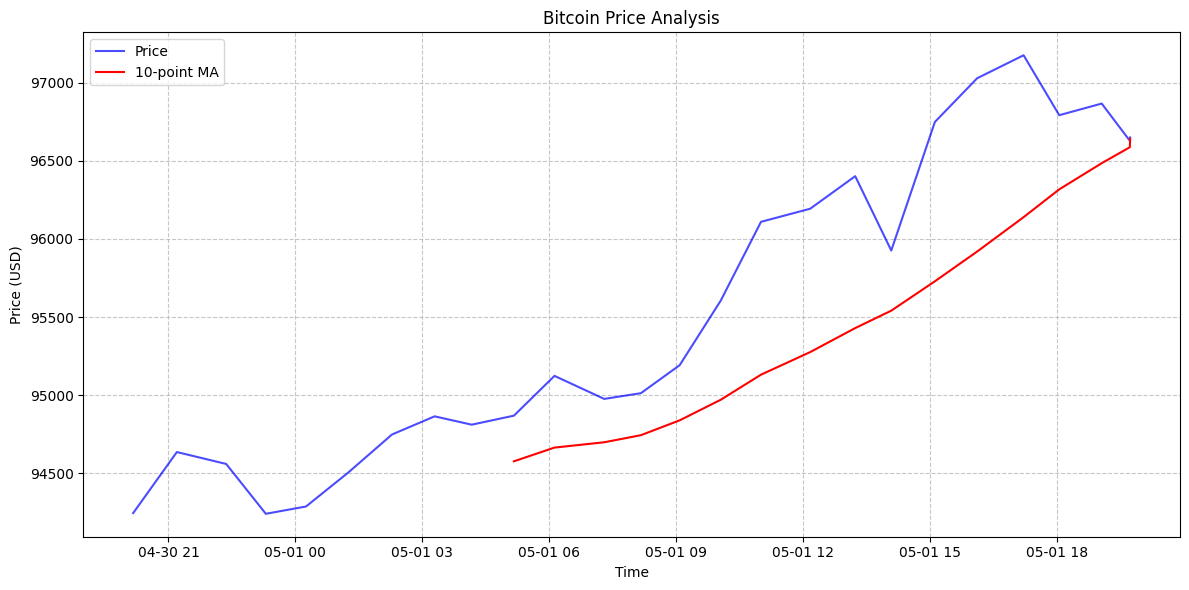

In [10]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot price data
ax.plot(df.index, df['price'], label='Price', color='blue', alpha=0.7)

# Plot moving averages if we have enough data
if 'ma_10' in df.columns and not df['ma_10'].isna().all():
    ax.plot(df.index, df['ma_10'], label='10-point MA', color='red')
if 'ma_30' in df.columns and not df['ma_30'].isna().all():
    ax.plot(df.index, df['ma_30'], label='30-point MA', color='green')

# Plot anomalies
if anomaly_count > 0:
    anomaly_points = df[anomalies]
    ax.scatter(anomaly_points.index, anomaly_points['price'], 
               color='red', marker='o', s=50, label='Anomalies')

# Set labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Price (USD)')
ax.set_title('Bitcoin Price Analysis')

# Add legend
ax.legend()

# Add grid
ax.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

## Real-time Updates with Redis Pub/Sub

Redis provides a Pub/Sub messaging system that we can use for real-time price updates. Here's a demonstration of publishing and subscribing to price updates.


### Pub/Sub

In [12]:
# Create a subscription to the Bitcoin price updates channel
pubsub = create_subscriber(redis_conn, channel='bitcoin_price_updates')

# Publish a price update
bitcoin_data = fetch_bitcoin_price() 
receivers = publish_price_update(redis_conn, bitcoin_data)
print(f"Published price update to {receivers} receivers")

# Wait a moment for the message to be processed
time.sleep(0.1)

# Get one message from the channel
message = pubsub.get_message()
print("Received message:", message)

if message and message.get('type') == 'message':
    data = json.loads(message.get('data', '{}'))
    print(f"Bitcoin price: ${data.get('usd', 0):,.2f}")

# Clean up
pubsub.unsubscribe()

2025-05-01 15:49:13,267 - Redis_utils - INFO - Subscribed to channel: bitcoin_price_updates


2025-05-01 15:49:13,504 - Redis_utils - INFO - Successfully fetched Bitcoin price: 96570 USD
2025-05-01 15:49:13,624 - Redis_utils - INFO - Published price update to 1 subscribers


Published price update to 1 receivers
Received message: {'type': 'subscribe', 'pattern': None, 'channel': 'bitcoin_price_updates', 'data': 1}
